# Data Analytics SoSe 2021
## Gruppenmitglieder: Anja Stricker, Annika Stadelmann

### Inhaltsverzeichnis


* [Aufgabe 1: Datenvorbereitung](#aufgabe1)
    * [Aufgabe 1a](#aufgabe1a)
    * [Aufgabe 1b](#aufgabe1b)
    * [Aufgabe 1c](#aufgabe1c)
    * [Aufgabe 1d](#aufgabe1d)
    * [Aufgabe 1e](#aufgabe1e)
    * [Aufgabe 1f](#aufgabe1f)
    * [Aufgabe 1g](#aufgabe1g)
* [Checkpoint](#checkpoint1)
* [Aufgabe 2: Explorative Datenanalyse](#aufgabe2)
    * [Aufgabe 2a](#aufgabe2a)
    * [Aufgabe 2b](#aufgabe2b)
    * [Aufgabe 2c](#aufgabe2c)
    * [Aufgabe 2d](#aufgabe2d)
    * [Aufgabe 2e](#aufgabe2e)
    * [Aufgabe 2f](#aufgabe2f)
    * [Aufgabe 2g](#aufgabe2g)
* [Aufgabe 3: Analyse der historischen Entwicklung der Kraftstoffpreise](#aufgabe3)
    * [Aufgabe 3a](#aufgabe3a)
    * [Aufgabe 3b](#aufgabe3b)
    * [Aufgabe 3c](#aufgabe3c)
* [Aufgabe 4: Abh angigkeit zwischen dem Roh olpreis und den Kraftstoffpreisen](#aufgabe4)
    * [Aufgabe 4a](#aufgabe4a)
    * [Aufgabe 4b](#aufgabe4b)
    * [Aufgabe 4c](#aufgabe4c)
* [Aufgabe 5: Einfluss des Wettbewerbs auf die Kraftstoffpreise in Bayern](#aufgabe5)
* [Checkpoint](#checkpoint2)
* [Aufgabe 6: Tanken in Amberg, Interaktives Diagramm](#aufgabe6)
* [Checkpoint](#checkpoint3)

## Import Block
#### Hier sind alle Import Anweisungen gebündelt 

In [101]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="DA_stud")
import json
import matplotlib.pyplot as plt
import folium
import math
from folium.plugins import MarkerCluster
import copy
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
import plotly.express as px

## Aufgabe 1 <a id="aufgabe1"></a>
#### (Datenvorbereitung)
Lesen Sie den unter der o.g. Adresse verfügbaren Tankstellendatensatz zum Stand 31.05.2021
in einen DataFrame namens df_stations ein. Dieser soll in dieser Aufgabe für die weitere
Verwendung vorbereitet werden.

In [102]:
df_stations = pd.read_csv("2021-05-31-stations.csv")

a) <a id="aufgabe1a"></a> Untersuchen Sie den Datensatz auf fehlende Werte und setzen Sie ggf. eine geeignete Strategie um, um mit diesen zu verfahren. Begründen Sie Ihr Vorgehen.

Zunächst verschaffen wir uns einen Überblick über die Anzahl an NaN Werten zu jeder Spalte. 

In [103]:
df_stations.isnull().sum()

uuid                    0
name                    0
brand                 670
street                  3
house_number         2940
post_code               3
city                    4
latitude                0
longitude               0
first_active            0
openingtimes_json       0
dtype: int64

Im folgenden werden nur noch die Spalten betrachtet die einen NaN Wert haben.
Alle Spalten mit 0 haben keine NaN Werte und müssen demnach nicht nochmal kontrolliert werden.

NaN Werte werden durch passende Werte ersetzt.
Für die Spalten "brand" und "openingtimes_json" wollten wir kein Leerzeichen stehen lassen und setzten deswegen "no brand"/"no data" um klarzumachen, dass es für diese Station keine Daten zu den Spalten gibt.

In [104]:
df_stations["brand"] = df_stations["brand"].fillna("no brand")
df_stations["openingtimes_json"] = df_stations["openingtimes_json"].replace("{}", "no data")

Da wir im nächsten Schritt die Geokoordinaten benutzen wollen, um die fehlenden Werte "street", "city" und "post_code" zu ermitteln, wollen wir bereits hier die Koordinaten auf unphysikalische und ungültige Werte filtern. Zunächst betrachten wir die Geokoordinaten in einem Histogramm.

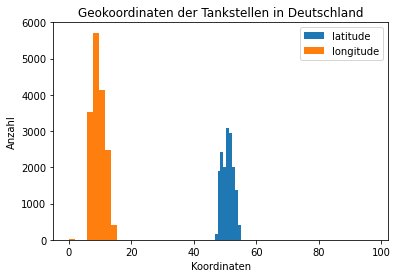

In [105]:
plt.hist(df_stations["latitude"], 60, label='latitude')
plt.hist(df_stations["longitude"], 50, label='longitude')
plt.legend(loc='upper right')
plt.title("Geokoordinaten der Tankstellen in Deutschland")
plt.xlabel('Koordinaten') 
plt.ylabel('Anzahl')
plt.show()

Bei Longitude & Latitude sind Ausreißer bei 0.0 zu erkennen. Diese werden in einem späteren Schritt rausfiltern.
Um die unphysikalischen und ungütligen Werte nicht mehr in den folgenden Analysen zu betrachten, werden sie aus dem DataFrame gefiltert.

In [106]:
df_stations = df_stations.loc[(df_stations["latitude"] <= 90.0) & (df_stations["latitude"] >= -90.0) & (df_stations["longitude"] <= 180.0) & (df_stations["longitude"] >= -180.0)]

Jetzt werden fehlende Einträge von street, house_number, city und post_code mit geopy ermittelt und ersetzt.

In [107]:
for i in tqdm(df_stations.loc[df_stations["street"].isnull() | df_stations["city"].isnull() | df_stations["post_code"].isnull()].index):
    data = df_stations.iloc[i]
    if ((data["latitude"] != 0.0) & (data["longitude"] != 0.0)):
        location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
        adressData = location.raw["address"]
        if "road" in adressData:
            df_stations.at[i, "street"] = adressData["road"]
        if "town" in adressData:
            df_stations.at[i, "city"] = adressData["town"]
        if "postcode" in adressData:
            df_stations.at[i, "post_code"] = adressData["postcode"]

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


In [108]:
for i in tqdm(df_stations.loc[df_stations["house_number"].isnull()].index):
    data = df_stations.iloc[i]
    if ((data["latitude"] != 0.0) & (data["longitude"] != 0.0)):
        location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
        adressData = location.raw["address"]
        if "house_number" in adressData:
            df_stations.at[i, "house_number"] = adressData["house_number"]

100%|██████████| 2940/2940 [24:28<00:00,  2.00it/s]


Die restlichen NaN Werte, die nicht durch Geopy ermittelt und ersetzt werden konnten, werden mit fillna auf einen default Wert (""/0) gesetzt.

In [109]:
df_stations["street"] = df_stations["street"].fillna("")
df_stations["post_code"] = df_stations["post_code"].fillna(0)
df_stations["city"] = df_stations["city"].fillna("")
df_stations["house_number"] = df_stations["house_number"].fillna(0)
df_stations.isnull().sum()

uuid                 0
name                 0
brand                0
street               0
house_number         0
post_code            0
city                 0
latitude             0
longitude            0
first_active         0
openingtimes_json    0
dtype: int64

Was man durch den isnull() Check nicht sehen konnte, ist, dass es viele Latitude- und Longitude-Werte mit 0.0 gibt. Diese konnten wir bereits in dem Histogramm weiter oben ausfindig machen.

Diese fehlerhaften Werte müssen ebenfalls korrigiert und ersetzt werden. Dies geschiet erneut mit Geopy.
Dazu verwenden wir die Adressdaten "street", "post_code" und "city", und holen uns so die Geokoordinaten.

In [110]:
df_stations.loc[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)]

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
12191,183311cd-53cd-4779-a829-3f91a0e2c3e8,please delete - bitte loeschen,no brand,please delete - bitte loeschen,0,00000,please delete - bitte loeschen,0.0,0.0,2014-03-18 16:45:31+01,no data
13814,00061525-0001-4444-8888-acdc00000001,Eurotank,Eurotank,Talstraße 26,0,58332,Schwelm,0.0,0.0,2014-08-22 00:00:01+02,no data
14200,4e8ecfc5-5d0d-4463-901b-6b9ff8fee510,01_test,no brand,,0,0,,0.0,0.0,2015-05-27 00:00:01+02,no data
15035,460e7b9d-3482-4191-933e-5682a7e5755f,Raiffeisen Hohe Mark Hamaland eG,no brand,Südring 20 ,26,46342,Velen,0.0,0.0,2017-10-17 19:01:15+02,no data
15342,dac5e971-9926-4464-acd9-a10294d448ec,ZIEGLMEIER GmbH & Co.KG,no brand,Friedrichshofener Str.,86,85049,Ingolstadt,0.0,0.0,2018-06-04 23:30:07+02,no data
15945,00062522-57b3-4444-8888-acdc00062522,Autohaus Rickmeier GmbH,Freie Tankstelle,Meinbrexer Str.,5,37697,Lauenförde,0.0,0.0,2020-02-12 02:01:15+01,no data
16074,ce830342-ebca-4bf8-9593-653341732a59,Hh Admi-Testkasse,OIL!,Admi55,0,12345,Hh Admi-Testkasse,0.0,0.0,2020-09-16 08:01:15+02,no data
16121,00062571-1f48-4444-8888-acdc00000001,Autohaus Franz Saaler OHG,Autohaus Franz Saaler OHG,Bergstr.,1,79737,Herrischried,0.0,0.0,2020-11-11 14:01:14+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
16244,00062345-b3f5-4444-8888-acdc00000002,Tankstelle Zajelsnik,Freie Tankstelle Zajelsnik,Mülhauserstrasse,2,79110,Freiburg,0.0,0.0,2021-03-15 14:01:13+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
16245,00060445-2e01-4444-8888-acdc00000001,Tankhof Kenzingen,Tankhof Kenzingen,Dieselstrasse,3,79341,Kenzingen,0.0,0.0,2021-03-15 14:01:13+01,"{""openingTimes"":[{""applicable_days"":127,""perio..."


In [111]:
for i in tqdm(df_stations.loc[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)].index):
    data = df_stations.iloc[i]

    if ((data["street"] != "") & (data["post_code"] != "") & (data["city"] != "")):

        loc = (data["street"] + " " + data["post_code"] + " " + data["city"])
        print(loc)
        
        location = geolocator.geocode(loc)        

        if location != None:
            df_stations.at[i, "latitude"] = location.latitude
            df_stations.at[i, "longitude"] = location.longitude

 10%|█         | 1/10 [00:00<00:01,  5.09it/s]

please delete - bitte loeschen 00000 please delete - bitte loeschen
Talstraße 26 58332 Schwelm


 20%|██        | 2/10 [00:00<00:03,  2.26it/s]

Südring 20  46342 Velen


 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

Friedrichshofener Str. 85049 Ingolstadt


 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

Meinbrexer Str. 37697 Lauenförde


 60%|██████    | 6/10 [00:02<00:01,  2.55it/s]

Admi55 12345 Hh Admi-Testkasse


 70%|███████   | 7/10 [00:02<00:01,  2.34it/s]

Bergstr. 79737 Herrischried


 80%|████████  | 8/10 [00:03<00:00,  2.21it/s]

Mülhauserstrasse 79110 Freiburg


 90%|█████████ | 9/10 [00:03<00:00,  2.13it/s]

Dieselstrasse 79341 Kenzingen


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Jetzt prüfen wir ob alle Werte mit 0.0 ersetzt wurden.

In [112]:
df_stations.loc[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)]

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
12191,183311cd-53cd-4779-a829-3f91a0e2c3e8,please delete - bitte loeschen,no brand,please delete - bitte loeschen,0,00000,please delete - bitte loeschen,0.0,0.0,2014-03-18 16:45:31+01,no data
14200,4e8ecfc5-5d0d-4463-901b-6b9ff8fee510,01_test,no brand,,0,0,,0.0,0.0,2015-05-27 00:00:01+02,no data
16074,ce830342-ebca-4bf8-9593-653341732a59,Hh Admi-Testkasse,OIL!,Admi55,0,12345,Hh Admi-Testkasse,0.0,0.0,2020-09-16 08:01:15+02,no data


Diese drei Einträge konnten nicht ersetzt werden, da es unzureichende Daten für Geopy gab, also keine "street", "post_code" und "city".
Da wir hier jedoch auch sehen, dass alle drei Datensätze beliebige Testwerte haben, und für die weitere Verarbeitung irrelevant sind, entfernen wir diese Zeilen mit dem Drop Befehl.

In [113]:
df_stations.drop(df_stations[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)].index, inplace=True)

Zum Schluss wollen wir noch den Typen der "post_code" Spalte anpassen, damit wir diese im weiteren Verlauf besser verarbeiten können.
Hierzu wandeln wir den String in einen float um, welcher in der letzten Befehlszeile in ein int64 umgewandelt wird.

In [114]:
df_stations["post_code"] = df_stations["post_code"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df_stations.dropna(subset = ["post_code"], inplace=True)
np.isnan(df_stations['post_code']).sum()
df_stations["post_code"] = df_stations["post_code"].astype(np.int64)

Citys die einen NaN Wert haben, aber einen Postcode, werden mit den anderen Postcode Einträgen verglichen und erhalten den Namen der City.

In [115]:
def findCityWithPostcode(row):
    test = df_stations["city"][(df_stations["post_code"] == row["post_code"]) & (df_stations["city"].notnull())].item()
    if (len(test) > 0):
        return test
    else:
        return ""
df_stations["city"] = df_stations[["city", "post_code"]].apply(lambda x: findCityWithPostcode(x) if x["city"] is np.nan else x["city"], axis=1)

Damit wir keine doppelten Städte mit Umlauten haben, ersetzten wir diese ebenfalls.

In [116]:
df_stations["city"] = df_stations["city"].str.replace(u"Ü", "UE")
df_stations["city"] = df_stations["city"].str.replace(u"Ö", "OE")
df_stations["city"] = df_stations["city"].str.replace(u"Ä", "AE")

Zum Schluss prüfen wir ob wir alle NaN Werte erfolgreich korrigiert und ermittelt haben.

In [117]:
df_stations.isnull().sum()

uuid                 0
name                 0
brand                0
street               0
house_number         0
post_code            0
city                 0
latitude             0
longitude            0
first_active         0
openingtimes_json    0
dtype: int64

b) <a id="aufgabe1b"></a> Transformieren Sie die Spalten brand, street und city, sodass die Werte jeweils nur
in Großbuchstaben ausgeben werden.

Hierzu wenden wir die Funktion upper() auf die genannten drei Spalten an.

In [118]:
df_stations["brand"] = df_stations["brand"].str.upper()
df_stations["street"] = df_stations["street"].str.upper()
df_stations["city"] = df_stations["city"].str.upper()

c) <a id="aufgabe1c"></a> Überprüfen Sie, ob der Datensatz Duplikate enthält und entfernen Sie diese ggf. Ein Duplikat liege dann vor, wenn zwei Tankstellen in den Spalten name, street, house number und post code übereinstimmen. Geben Sie aus, wie viele Duplikate ermittelt und entfernt wurden.

Es wurden 48 Duplikate ermittelt und im Folgenden vollständig entfernt. Dazu wurde der erste Datensatz behalten.

In [119]:
df_stations[["name", "street", "house_number", "post_code"]].duplicated().sum()

48

Damit durch das drop_duplicates unsere Indexwerte in df_stations nicht korrupt bleiben, wird der Index resettet. Dadurch werden die fehlenden Indexlücken beseitigt und wir erhalten einen sauberen Indexverlauf.

In [120]:
df_stations.drop_duplicates(subset = {"name", "street", "house_number", "post_code"}, keep =  "first", inplace = True)
df_stations = df_stations.reset_index(drop=True)
df_stations[["name", "street", "house_number", "post_code"]].duplicated().sum()

0

d) <a id="aufgabe1d"></a> Untersuchen Sie die Spalten longitude und latitude auf unphysikalische Werte, indem Sie zunächst deren Verteilung in einem Histogramm visualisieren. Entfernen oder korrigieren Sie anschließend die Einträge zu denjenigen Tankstellen, bei denen Sie unphysikalische Werte festgestellt haben. Zeichnen Sie anschließend erneut Histogramme für die beiden Spalten longitude und latitude.

Die Analyse der Longitude- und Latitude-Werte haben wir bereits in Aufgabe 1 a) durchgeführt. Die unphysikalischen und ungütligen Werte wurden gefiltert oder gelöscht.
Nun geben wir erneut ein Histogram aus um uns die neuen Resulate anzusehen.

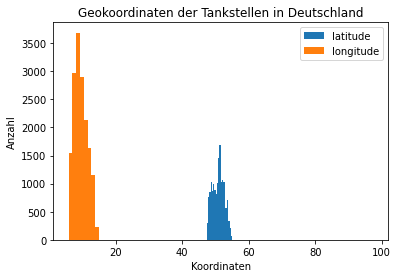

In [121]:
plt.hist(df_stations["latitude"], 20, label='latitude')
plt.hist(df_stations["longitude"], 80, label='longitude')
plt.legend(loc='upper right')
plt.title("Geokoordinaten der Tankstellen in Deutschland")
plt.xlabel('Koordinaten') 
plt.ylabel('Anzahl')
plt.show()

e) <a id="aufgabe1e"></a> Reichern Sie den Tankstellendatensatz um die Spalte state an, die das Bundesland enthalten soll, in dem sich die Tankstelle befindet. Erzeugen Sie durch Filterung einen DataFrame
namens df_stations_BY, der die Informationen zu allen Tankstellen in Bayern enthalt.

Um die States zu den einzelnen Zeilen nicht langwierig mit Geopy ermitteln zu müssen, haben wir uns für die Benutzung eines extra Datensatzes entschieden, welche die Informationen zu den jeweiligen post_codes enthält. Diese lesen wir zunächst ein.

Quelle des Datensatzes: https://www.suche-postleitzahl.org/downloads

In [122]:
df_bundesland_plz = pd.read_csv("zuordnung_plz_ort_landkreis.csv")
df_bundesland_plz.head()

,osm_id,ags,ort,plz,landkreis,bundesland
0,1104550,8335001,Aach,78267,Landkreis Konstanz,Baden-Württemberg
1,1255910,7235001,Aach,54298,Landkreis Trier-Saarburg,Rheinland-Pfalz
2,62564,5334002,Aachen,52062,Städteregion Aachen,Nordrhein-Westfalen
3,62564,5334002,Aachen,52064,Städteregion Aachen,Nordrhein-Westfalen
4,62564,5334002,Aachen,52066,Städteregion Aachen,Nordrhein-Westfalen


Nun erstellen wir ein Dictionary, welches die Post Codes und Bundesländer enthält, und mappen diese mit dem post_code auf unseren df_stations DataFrame.
Die neuen Werte werden in der neuen Spalte "state" abgespeichert.

In [123]:
plz_bundesland_dict = {}

for i, j in zip(df_bundesland_plz.plz, df_bundesland_plz.bundesland):
    plz_bundesland_dict[i] = j

Jetzt prüfen wir, ob wir zu allen Zeilen state Werte setzten konnten.

In [124]:
df_stations["state"] = df_stations["post_code"].map(plz_bundesland_dict)
df_stations.isnull().sum()

uuid                  0
name                  0
brand                 0
street                0
house_number          0
post_code             0
city                  0
latitude              0
longitude             0
first_active          0
openingtimes_json     0
state                39
dtype: int64

Die 39 Bundesländer, die nun NaN sind, werden abschließend mit Geopy ermittelt.

In [125]:
for i in tqdm(df_stations.loc[df_stations["state"].isnull()].index):
    data = df_stations.iloc[i]
    location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
    adressData = location.raw["address"]
    if "state" in adressData:
        df_stations.at[i, "state"] = adressData["state"]

df_stations["state"].isnull().sum()

100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


0

Nun Erzeugen wir den neuen Dataframe df_stations_BY.

In [126]:
df_stations_BY = df_stations.loc[df_stations["state"] == "Bayern"]

## Checkpoint Aufgabe 1e, df_stations, df_stations_BY <a id="checkpoint1"></a>

Speichern der Datensätze

In [127]:
df_stations.to_csv("state_1e_df_stations.csv", index=False)

In [128]:
df_stations_BY.to_csv("state_1e_df_stations_BY.csv", index=False)

Einlesen der Datensätze

In [129]:
df_stations = pd.read_csv("state_1e_df_stations.csv")

In [130]:
df_stations_BY = pd.read_csv("state_1e_df_stations_BY.csv")

## Aufgabe 1 weiterführend

Lesen Sie nun den Preise-Datensatz aus dem GitLab-Repository in einen DataFrame namens
df_prices_BY ein. Dieser wurde durch Filterung der auf der Tankerkönig-Seite verfügbaren Preise-Datensatze erzeugt und enthält die Angaben zur historischen Preisen und Preisänderungen an den Tankstellen in Bayern im Betrachtungszeitraum zwischen Januar 2018 und Mai 2021.

In [131]:
df_prices_BY = pd.read_csv("prices_BY.csv")

f) <a id="aufgabe1f"></a> Untersuchen Sie die Kraftstoffpreise auf Ausreißer und entfernen Sie diese ggf.

Zuerst lassen wir uns die Kraftstoffpreise in einem Histgram ausgeben, um die Daten auf Ausreißer analysieren zu können.

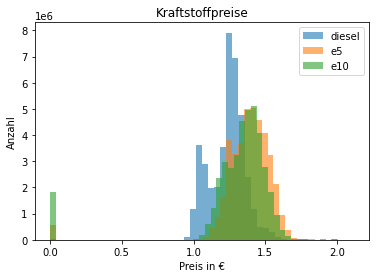

In [132]:
plt.hist(df_prices_BY["diesel"], 50, label='diesel', alpha=0.6)
plt.hist(df_prices_BY["e5"], 50, label='e5', alpha=0.6)
plt.hist(df_prices_BY["e10"], 50, label='e10', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Kraftstoffpreise")
plt.xlabel('Preis in €') 
plt.ylabel('Anzahl')
plt.show()

Durch das Histogram lässt sich nun erkennen, dass es fehlerhafte Werte mit 0.0 gibt, diese sollen durch np.nan ersetzt werden.
Außerdem möchten wir auftretende Preise unter 0.5 ebenfalls zu np.nan umwandeln.

In [133]:
df_prices_BY["e10"] = df_prices_BY["e10"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["e10"] < 0.5] = np.nan
df_prices_BY["e5"] = df_prices_BY["e5"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["e5"] < 0.5] = np.nan
df_prices_BY["diesel"] = df_prices_BY["diesel"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["diesel"] < 0.5] = np.nan

Nun wollen wir uns die Ergebnisse erneut in einem Histogram anschauen.

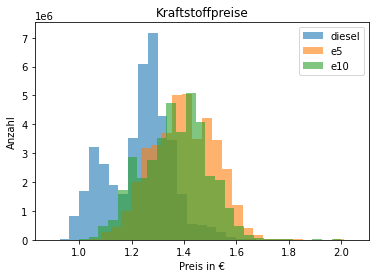

In [134]:
plt.hist(df_prices_BY["diesel"], 30, label='diesel', alpha=0.6)
plt.hist(df_prices_BY["e5"], 30, label='e5', alpha=0.6)
plt.hist(df_prices_BY["e10"], 30, label='e10', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Kraftstoffpreise")
plt.xlabel('Preis in €') 
plt.ylabel('Anzahl')
plt.show()

Die fehlerhaften Werte sind weg und wir können nun schöne Preiskurven für die Kraftstoffpreise betrachten.

g) <a id="aufgabe1g"></a> Überführen Sie die Spalte date in ein DateTime-Format.

In [135]:
df_prices_BY["date"] = pd.to_datetime(df_prices_BY["date"], infer_datetime_format=True, utc=True)
df_prices_BY["date"].head()

0   2017-12-31 23:01:06+00:00
1   2017-12-31 23:02:06+00:00
2   2017-12-31 23:03:05+00:00
3   2017-12-31 23:05:06+00:00
4   2017-12-31 23:07:06+00:00
Name: date, dtype: datetime64[ns, UTC]

## Aufgabe 2 <a id="aufgabe2"></a>
#### (Explorative Datenanalyse)
In dieser Aufgabe sind erste einfache Analysen durchzuführen und Visualisierungen zu erstellen.

a) <a id="aufgabe2a"></a> Wie viele Tankstellen gibt es insgesamt in Deutschland? Wie viele pro Bundesland?

Zunächst wurde die Zahl an Tankstellen in Deutschland ausgegeben. Es handelt sich um insgesamt 16247 Tankstellen.
Die einfachste Variante, die Tankstellen zu zählen, war die Länge des DataFrames ausugeben, da dieser nach Aufgabe 1 nun auch keine Duplikate mehr enthält.

In [136]:
len(df_stations)

16247

Mit der Methode "value_counts()" konnte auch die Anzahl der Tankstellen ermittelt werden. Die Tankstellen im jeweiligen Bundesland wurden hier aufsummiert und man kann sich einen guten Überblick darüber verschaffen.

In [137]:
df_stations["state"].value_counts()

Nordrhein-Westfalen       3350
Bayern                    2777
Baden-Württemberg         2103
Niedersachsen             2056
Hessen                    1280
Rheinland-Pfalz            859
Schleswig-Holstein         660
Sachsen                    618
Sachsen-Anhalt             476
Brandenburg                459
Thüringen                  443
Mecklenburg-Vorpommern     373
Berlin                     303
Hamburg                    214
Saarland                   172
Bremen                     104
Name: state, dtype: int64

b) <a id="aufgabe2b"></a> Welches sind die zehn Tankstellenmarken mit den meisten Niederlassungen in Deutschland?
Wie viele Niederlassungen sind es jeweils?

Die Tankstellen mit den meisten Niederlassungen in Deutschland werden am einfachsten ermittelt, indem man auf die Spalte "brand" die Funktion "value_counts()" anwendet. Anschließend wird die Ausgabe mit "head(10)" auf die zehn Marken, die vorherrschend in Deutschland sind, beschränkt. Mit "dict()" wird das Ganze in einem Dictionary gespeichert, was die Daten übersichtlicher macht.

In [138]:
meisteMarken = dict(df_stations['brand'].value_counts().head(10))
meisteMarken

{'ARAL': 2421,
 'SHELL': 1848,
 'ESSO': 1134,
 'TOTAL': 921,
 'AVIA': 730,
 'JET': 697,
 'NO BRAND': 658,
 'STAR': 577,
 'BFT': 485,
 'AGIP': 457}

c) <a id="aufgabe2c"></a> Welcher Anteil der Tankstellen hat Sonntags geöffnet?

Begonnen wurde mit zwei Dictionarys: Eines, in dem die Öffnungszeiten an Sonntagen eingetragen wurde (Voraussetzung hierfür war, dass der jeweilige Datensatz einen Eintrag zu den Öffnungszeiten enthielt) und ein Weiteres, in dem die Tankstellen, die keine Öffnungszeiten beinhalteten oder die, die fehlerhafte Einträge besitzen, enthalten sind.

In [139]:
openingTimes = df_stations['openingtimes_json']
openOnSunday = {"Sonntags geöffnet": 0, "Sonntags geschlossen": 0}
errorData = {"Keine Öffnungszeit": 0, "Fehlerhaft": 0}

for x in openingTimes:
    if x != "no data":
        if "openingTimes" in json.loads(x):
            foundSunday = False
            for y in json.loads(x)["openingTimes"]:
                bitValue = y["applicable_days"]
                mask = 1 << 6
                if (bitValue & mask == mask):
                    openOnSunday["Sonntags geöffnet"] += 1
                    foundSunday = True
                    break
            if (foundSunday == False):
                openOnSunday["Sonntags geschlossen"] += 1
        else:
            errorData["Fehlerhaft"] += 1
    else:
        errorData["Keine Öffnungszeit"] += 1

openOnSunday

{'Sonntags geöffnet': 8403, 'Sonntags geschlossen': 594}

Der Anteil der Tankstellen, die Sonntags geöffnet haben in dem Dictionary, das tatsächlich Öffnungszeiten enthält, wurde anschließend in einem Kuchendiagramm visualisiert. So kann man auf einen Blick erkennen, dass es 93.40% der Tankstellen sind, an denen man auch Sonntags Kunde werden kann.

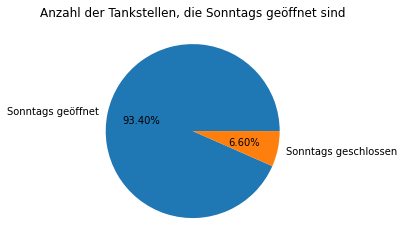

In [140]:
def pie_label_formatter(x):
    return '{:.2f}%'.format(x)

plt.pie(openOnSunday.values(), labels = openOnSunday.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der Tankstellen, die Sonntags geöffnet sind")
plt.show()

Auch wurde das Dictionary, welches fehlerhafte oder keine Öffnungszeiteneinträge enthält visualisiert. Es zeigt, dass 98.50% dieser Tankstellen keine Öffnungszeiten angegeben haben, während 1.50% der Daten fehlerhaft waren.

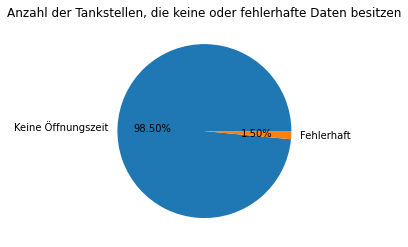

In [141]:
plt.pie(errorData.values(), labels = errorData.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der Tankstellen, die keine oder fehlerhafte Daten besitzen")
plt.show()

Um nocheinmal einen Gesamtüberblick zu zeigen, wurde das "openOnSunday"-Dictionry kopiert. Hierbei wurde eine tiefe Kopie vorgenommen, da sonst das ursprüngliche Dictionary verändert würde.
Anschließend wurde das neu angelegte Dictionary und "errorData" zusammengeführt, um danach ein Kuchendiagramm über alle Werte zu erzeugen.

In [142]:
oeffnungszeitenGesamt = copy.deepcopy(openOnSunday)
oeffnungszeitenGesamt.update(errorData)
oeffnungszeitenGesamt

{'Sonntags geöffnet': 8403,
 'Sonntags geschlossen': 594,
 'Keine Öffnungszeit': 7141,
 'Fehlerhaft': 109}

Das nachfolgende Diagramm zeigt die prozentualen Anteile der Öffnungszeiten des gesamten DataFrames. So haben über 50% der Tankstellen in Deutschland am Sonntag geöffnet, während bei 43.95% keine Öffnungszeiten angegeben sind. Man kann also nicht ausschließen, dass es noch mehr Tankstellen gibt, an denen man Sonntag tanken kann.

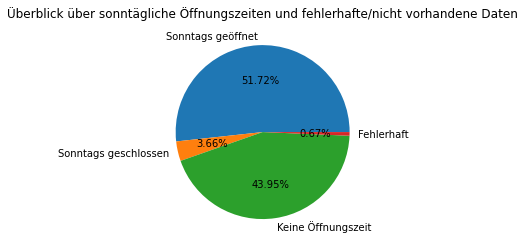

In [143]:
plt.pie(oeffnungszeitenGesamt.values(), labels = oeffnungszeitenGesamt.keys(), autopct=pie_label_formatter)
plt.title("Überblick über sonntägliche Öffnungszeiten und fehlerhafte/nicht vorhandene Daten")
plt.show()

d) <a id="aufgabe2d"></a> Visualisieren Sie in einem Kreisdiagramm die Zusammensetzung des Marktes in freie Tankstellen und Markentankstellen. Nehmen Sie vereinfachend an, dass eine Tankstelle dann
eine freie Tankstelle ist, wenn sie gemäß der Spalte "brand" einer Marke angehört, die bundesweit höchstens 20 Niederlassungen betreibt.

Zuerst wurde eine Liste mit allen möglichen Marken angelegt, die anschließend in ein Dictionary konvertiert wurden. 
Danach wurde in der for-Schleife gezählt, wie viele Tankstellen der jeweiligen Marke angehören.
In einem neuen Dictionary, welches Marken- und freie Tankstellen und deren Anzahl beinhaltet, wurde nun mit Hilfe einer for-Schleife ermittelt, welche Tankstellenmarken öfter als 20-mal vorkommen und welche nicht. Je nachdem wurden die Werte in das Dictionary eingetragen.

In [144]:
brand = list(df_stations['brand'].value_counts().index)

def Convert(lst):
    res_dct = {lst[i]: 0 for i in range(0, len(lst), 1)}
    return res_dct

lst = Convert(brand)

for x in df_stations["brand"]:
    if x in lst:
        lst[x] += 1

tankstellenListe = {"Markentankstellen": 0, "Freie Tankstellen": 0}

for x in lst.values():
    if x > 20:
        tankstellenListe["Markentankstellen"] += x
    else:
        tankstellenListe["Freie Tankstellen"] += x
tankstellenListe

{'Markentankstellen': 14422, 'Freie Tankstellen': 1825}

Das Kuchendiagramm zeigt nun, dass fast 90% der Tankstellen in Deutschland einer Marke angehören, die mindestens 20 Niederlassungen in Deutschland hat.

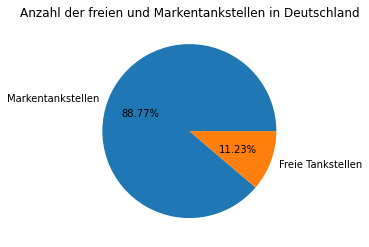

In [145]:
plt.pie(tankstellenListe.values(), labels = tankstellenListe.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der freien und Markentankstellen in Deutschland")
plt.show()

e) <a id="aufgabe2e"></a> Wie häufig wird an den bayerischen Tankstellen durchschnittlich pro Tag im Betrachtungszeitraum ein Datensatz an die Markttransparenzstelle für Kraftstoffe übermittelt? 

Um herauszufinden, wie oft am Tag Daten an die Markttransparenzstelle für Kraftstoffe übermittelt wurden, wurde der Mittelwert eines jeden Tages gebildet und im "TagesDurchschnitt" festgehalten. Anschließend wurde dann der allgemeine Durchschnitt berechnet, welcher bei ungefähr 32029 liegt. 
Dies ist mit der Methode "mean()" sehr einfach zu berechnen.

In [146]:
TagesDurchschnitt = df_prices_BY["date"].groupby(df_prices_BY["date"].dt.date).count()
TagesDurchschnitt

date
2017-12-31       47
2018-01-01    22767
2018-01-02    26726
2018-01-03    25916
2018-01-04    26315
              ...  
2021-05-27    40995
2021-05-28    41213
2021-05-29    40143
2021-05-30    37518
2021-05-31    39738
Name: date, Length: 1248, dtype: int64

In [147]:
TagesDurchschnitt.mean()

32029.253205128207

f) <a id="aufgabe2f"></a> In welchen zehn bayerischen Städten war der durchschnittliche Diesel-Preis im Betrachtungszeitraum 2018-2021 am höchsten und wie hoch war er jeweils? In welchen zehn Städten war er am geringsten und wie hoch war er jeweils? 

Um Aufgabe 2f) zu beantworten, wurde zunächst ein DataFrame "combined_df" erstellt, welcher aus den Spalten "station_uuid" und "diesel" besteht.

In [148]:
combinedStations = df_prices_BY.groupby("station_uuid")["diesel"].mean()

In [149]:
combined_df = pd.DataFrame(combinedStations)
combined_df = combined_df.reset_index()

Damit der DataFrame später mit dem, der die Informationen über die Tankstellen enthält, zusammengeführt werden kann, muss die Spalte, die bei beiden die gleichen Werte innehat, umbenannt werden. In diesem Fall wurde aus "station_uuid" nur "uuid".

In [150]:
combined_df.rename(columns = {"station_uuid":"uuid"}, inplace="True")

Danach wurde "combined_df" mit den Spalten "uuid" und "city" des DataFrames "df_stations" zusammengeführt. Dies geschieht auf Basis der uuid, die beide DataFrames haben.
Auch hier wurde wieder der Durchschnitt der Preise gebildet, um nicht völlig abweichende Werte verwenden zu müssen.

In [151]:
combined_df = combined_df.merge(df_stations[["uuid", "city"]])
combined_df = combined_df.groupby("city")["diesel"].mean()
combined_df = pd.DataFrame(combined_df)
combined_df = combined_df.reset_index()

Nachfolgend sieht man die zehn Städte, in denen die Dieselpreise durchschnittlich am höchsten waren.

In [152]:
combined_df.sort_values(by=["diesel"], inplace=True, ascending=False)
combined_df[0:10]

,city,diesel
489,ILLSCHWANG,1.524630
423,HAUSEN BEI WÜRZBURG,1.522842
545,KLEINLANGHEIM - HAIDT (SÜD),1.502727
583,LANDSBERG LECH,1.501544
124,BERGEN / CHIEMGAU,1.497545
582,LANDSBERG AM LECH,1.497352
730,NEUFAHRN B.FREISING,1.493707
324,FÜRHOLZEN,1.487962
523,KIEFERSFELDEN,1.481179
810,OHRENBACH,1.451928


Hier sind die 10 Städte zu sehen, in denen der Dieselpreis durchschnittlich am geringsten war.

In [153]:
combined_df.sort_values(by=["diesel"], ascending=True).head(10)

,city,diesel
747,NEUSORG,1.052904
1125,WAGENHOFEN,1.101939
531,KIRCHENLAMITZ,1.102472
761,NIEDERFÜLLBACH,1.114648
1006,SENGENTHAL,1.121639
649,MAROLDSWEISACH,1.138882
316,FUCHSTAL-LEEDER,1.142259
1045,SÖCHTENAU,1.144537
200,DIEDORF-BIBURG,1.148111
466,HOLZHEIM,1.151712


g) <a id="aufgabe2g"></a> Erstellen Sie mit folium eine interaktive Karte, auf der die einzelnen Tankstellen in Bayern
als Marker (in einem Marker-Cluster) eingezeichnet sind. Beim Klick auf einen Marker soll
der Name der Tankstelle und deren Adresse angezeigt werden.

Um geeignete Marker-Cluster zu erstellen, wurde zunächst erneut die CSV-Datei eingelesen, welche die Postleitzahlen mit zugehörigen Bundesländern und Landkreisen enthält. 
Damit die DataFrames zusammengeführt werden können, wurde in "df_landkreise" der Spaltenname der Postleitzahl geändert.

In [154]:
df_landkreise = pd.read_csv("zuordnung_plz_ort_landkreis.csv")
df_landkreise.rename(columns = {"plz":"post_code"}, inplace="True")

Anschließend wurde zu "df_stations_BY" eine neue Spalte hinzugefügt, die die Information enthält, in welchem Landkreis sich die Tankstelle befindet.

In [155]:
df_stations_BY = df_stations_BY.merge(df_landkreise[["post_code", "landkreis"]])
df_stations_BY = pd.DataFrame(df_stations_BY)
df_stations_BY = df_stations_BY.reset_index()

Insgesamt wurden 71 Landkreise eingetragen. Daraus resultiert, dass es insgesamt 71 Marker-Cluster geben muss.

In [156]:
landkreise = list(df_stations_BY['landkreis'].value_counts().index)
len(landkreise)

71

Danach wurde der Mittelpunkt der Karte auf den Mittelpunkt Bayerns gesetzt. Die Koordinaten lauten: 48.9478033183036 und 11.404411169316944. 
Aus jedem der Landkreise wurde ein Marker-Cluster erstellt, welches die einzelnen Tankstellen des Landkreises als Marke beinhaltet. So sind die Cluster der Karte sinnvoll aufgeteilt und die Karte wirkt übersichtlicher. Auch lassen sich so bestimmte Tankstellen einfacher finden.

In [157]:
m = folium.Map(location=[48.9478033183036, 11.404411169316944], zoom_start=7, tiles="openstreetmap")

for x in landkreise:
    marker_cluster = MarkerCluster(name = x).add_to(m)
    for i in df_stations_BY.loc[df_stations_BY["landkreis"] == x].index:
        folium.Marker([df_stations_BY["latitude"][i], df_stations_BY["longitude"][i]], 
        popup=df_stations_BY["name"][i] + " " + df_stations_BY["street"][i] + " " + str(df_stations_BY["post_code"][i]) + " " + df_stations_BY["city"][i]).add_to(marker_cluster)

In [158]:
m

## Aufgabe 3  <a id="aufgabe3"></a>
#### (Analyse der historischen Entwicklung der Kraftstoffpreise)

a) <a id="aufgabe3a"></a> In welchem Monat im Betrachtungszeitraum waren die Kraftstoffpreise für Diesel in Bayern durchschnittlich am höchsten? In welchem am geringsten? Wie hoch waren die durchschnittlichen Preise jeweils?

Zunächst erstellen wir eine neue Series, welche den Monatsdurchschnitt zu den Dieselpreisen enthält. Diese wandeln wir dann in einen DataFrame um und sortieren ihn.

In [159]:
monthPrices = df_prices_BY.resample(rule='M', on='date')['diesel'].mean()
monthPrices_df = pd.DataFrame(monthPrices)
monthPrices_df = monthPrices_df.reset_index()

Am höchsten war der Preis im November, 2018

In [160]:
monthPrices_df.sort_values(by=["diesel"], inplace=True, ascending=False)
monthPrices_df.head(1)

,date,diesel
11,2018-11-30 00:00:00+00:00,1.505811


Am niedrigsten war der Preis im Oktober, 2020

In [161]:
monthPrices_df.tail(1)

,date,diesel
34,2020-10-31 00:00:00+00:00,1.043569


b) <a id="aufgabe3b"></a> Ermitteln Sie die Jahresdurchschnitte für die einzelnen Kraftstoffsorten in den Jahren 2018-2021 für die bayerischen Tankstellen. Visualisieren Sie diese in einem geeigneten Diagramm. Lassen sich Trends erkennen?

Dazu erstellen wir drei neue DataFrames, welche auf dem df_prices_BY basieren. Wir filtern nach dem "Y", also Year und bilden den Mittelwert zum entsprechenden Kraftstoff.

In [162]:
yearPrices_diesel = df_prices_BY.resample(rule='Y', on='date')['diesel'].mean()
yearPrices_diesel_df = pd.DataFrame(yearPrices_diesel)
yearPrices_diesel_df = yearPrices_diesel_df.reset_index()

In [163]:
yearPrices_e5 = df_prices_BY.resample(rule='Y', on='date')['e5'].mean()
yearPrices_e5_df = pd.DataFrame(yearPrices_e5)
yearPrices_e5_df = yearPrices_e5_df.reset_index()

In [164]:
yearPrices_e10 = df_prices_BY.resample(rule='Y', on='date')['e10'].mean()
yearPrices_e10_df = pd.DataFrame(yearPrices_e10)
yearPrices_e10_df = yearPrices_e10_df.reset_index()

Nun mergen wir die neuen drei DataFrames wieder in einen Gemeinsamen namens merged_year_prices.

In [165]:
merged_year_prices = yearPrices_diesel_df
merged_year_prices = merged_year_prices.merge(yearPrices_e5_df, on="date")
merged_year_prices = merged_year_prices.merge(yearPrices_e10_df, on="date")

merged_year_prices

,date,diesel,e5,e10
0,2017-12-31 00:00:00+00:00,1.276766,1.438556,1.417667
1,2018-12-31 00:00:00+00:00,1.311784,1.463215,1.441391
2,2019-12-31 00:00:00+00:00,1.285718,1.436302,1.414659
3,2020-12-31 00:00:00+00:00,1.114651,1.284120,1.250197
4,2021-12-31 00:00:00+00:00,1.294346,1.477144,1.421118


Damit das Diagramm übersichtlicher ist, trimmen wir das date Format auf das Jahr.

In [166]:
merged_year_prices["date"] = merged_year_prices['date'].dt.strftime('%Y')

Nun sortieren wir die Daten nach dem date, damit die Daten im Diagramm auch in der richtigen Reihenfolge angezeigt werden.

In [167]:
merged_year_prices.sort_values(by=["date"], inplace=True, ascending=True)

Durch das Diagramm lässt sich nun erkennen, dass es zu 2020 einen Tiefpunkt bei allen Kraftstoffpreisen gab, dieser hat sich jedoch in 2021 wieder erholt.
Was auch erkennbar ist, ist, dass die drei Krafstoffarten den gleichen preislichen Verlauf aufweisen.

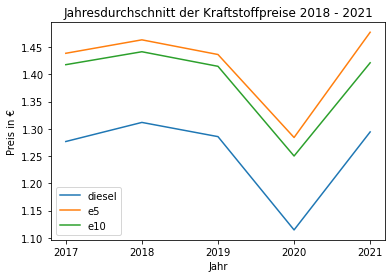

In [168]:
plt.plot("date", "diesel", data=merged_year_prices)
plt.plot("date", "e5", data=merged_year_prices)
plt.plot("date", "e10", data=merged_year_prices)
plt.xlabel("Jahr")
plt.ylabel("Preis in €")
plt.title("Jahresdurchschnitt der Kraftstoffpreise 2018 - 2021")
plt.legend()
plt.show()

c) <a id="aufgabe3c"></a> Visualisieren Sie auf geeignete Weise den zeitlichen Verlauf der Preise für die Kraftstoffe Diesel und Super E5 und Super E10 an den bayerischen Tankstellen zwischen 2018 und 2021. Beschreiben und interpretieren Sie Ihre Beobachtungen.

Zuerst erstellen wir einen neuen DataFrame mit den Durchschnittswerten zu den einzelnen Kraftstoffen und gruppieren diese nach den Tagen.

In [169]:
df_prices_BY

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2017-12-31 23:01:06+00:00,db9309c1-eb3f-4a2a-92ec-a374262facc9,1.274,NaN,NaN,1.0,0.0,0.0
1,2017-12-31 23:02:06+00:00,446bdcf5-9f75-47fc-9cfa-2c3d6fda1c3b,1.339,1.459,1.439,1.0,1.0,1.0
2,2017-12-31 23:03:05+00:00,a98ed5d0-261b-4311-beaf-85ee779fc4e0,1.289,1.439,1.419,1.0,1.0,1.0
3,2017-12-31 23:05:06+00:00,7fa4a726-3da5-4aca-afdb-161fbbac23b0,1.299,1.469,1.449,1.0,1.0,1.0
4,2017-12-31 23:07:06+00:00,742c6776-9f9e-45c9-87de-b27e3c5677a9,1.249,NaN,NaN,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
39992902,2021-05-31 21:48:08+00:00,771f41d1-12f0-4d71-b63e-2f2d784673e8,1.309,1.539,1.479,1.0,0.0,0.0
39992903,2021-05-31 21:48:08+00:00,9542a4b5-86c5-4daf-a7a9-b3041622934c,1.319,1.519,1.459,1.0,1.0,1.0
39992904,2021-05-31 21:49:10+00:00,a194baf4-a63a-4375-b97d-e2ec936133e5,1.299,1.509,1.449,1.0,1.0,1.0
39992905,2021-05-31 21:52:08+00:00,3909cebd-efae-11e7-ae1b-005056a2a083,1.269,1.479,1.419,1.0,1.0,1.0


In [170]:
dayprices = df_prices_BY.resample(rule="D", on="date")[["diesel", "e5", "e10"]].mean()

Nun können wir die Daten in einem Line Plot anzeigen. Hier kann man zunächst erkennen, dass die drei Kraftstoffarten einen ähnlichen Preisverlauf haben, und, dass es Anfang 2020 einen Preissturz gab, welcher sich jedoch bereits Anfang 2021 wieder erholt hat.

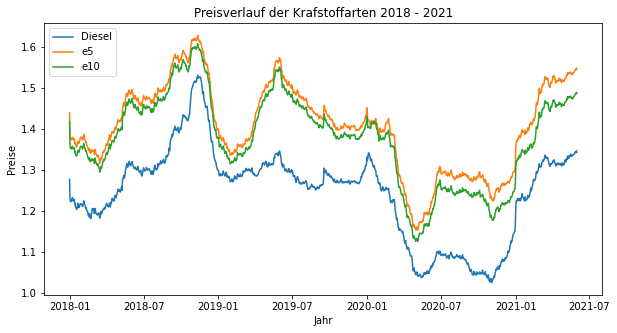

In [171]:
plt.figure(figsize=(10, 5))
plt.plot(dayprices["diesel"], label="Diesel")
plt.plot(dayprices["e5"], label="e5")
plt.plot(dayprices["e10"], label="e10")
plt.xlabel("Jahr")
plt.ylabel("Preise")
plt.title("Preisverlauf der Krafstoffarten 2018 - 2021")
plt.legend()
plt.show()

## Aufgabe 4 <a id="aufgabe4"></a>
#### (Abhängigkeit zwischen dem Rohölpreis und den Kraftstoffpreisen)

a) <a id="aufgabe4a"></a> Untersuchen Sie jeweils den Zusammenhang zwischen den Kraftstoffpreisen für Diesel bzw. Super E5 und dem Rohölpreis. Berechnen Sie dazu die Tagesmittelwerte für die Kraftstoffpreise für alle Tage im Betrachtungszeitraum 2018-2021 (für die bayerischen Tankstellen) und stellen Sie diese jeweils den Tagesschlusskursen für die Rohölsorte Brent Crude Oil (öffentlich verfügbar) in zwei Streudiagrammen (eines für Diesel und eines für E5) gegenüber. Laden Sie die verwendeten Ölpreis-Daten in Form einer CSV-Datei mit Ihrer Abgabe auf Moodle hoch.

Die Daten zum Brent-Crude-Oil-Preis wurden auf folgender Website gefunden und mit Hilfe eines CSV-Converters in eine CSV-Datei konvertiert:

https://www.finanzen.net/rohstoffe/oelpreis/historisch/euro?type=Brent 

https://www.convertcsv.com/csv-to-csv.htm

Die Tabelle zeigt den Ölpreis je Fass, was umgerechnet ca. 159 Litern entspricht.

In [172]:
brent_preise = pd.read_csv("Brent_Crude_öl_preise.csv")
brent_preise['Datum'] = pd.to_datetime(brent_preise['Datum'], errors='coerce', utc=True)
brent_preise["Datum"] = brent_preise['Datum'].dt.strftime('%Y-%m-%d')

In [173]:
brent_preise

,Datum,Schluss,Eröffnung,Tageshoch,Tagestief
0,2021-05-28,57.10,57.15,57.34,56.80
1,2021-05-27,56.96,56.40,57.00,55.85
2,2021-05-26,56.47,56.20,56.71,55.77
3,2021-05-25,56.04,55.89,56.24,55.37
4,2021-05-24,56.03,54.61,56.18,54.39
...,...,...,...,...,...
877,2018-08-01,56.62,56.64,56.80,56.34
878,2018-05-01,56.21,56.51,56.62,55.91
879,2018-04-01,56.39,56.24,56.55,56.01
880,2018-03-01,56.46,55.38,56.62,55.26


Um nun einen DataFrame zu erstellen, in dem die Rohölpreise und die Kraftstoffpreise kombiniert zu sehen sind, musste die Spalte "Datum" des DataFrames "brent_preise" in "date" umbenannt werden. Dies dient dem Vorgang, die beiden DataFrames zusammenzuführen. Diese Zusammenführung wird mittels des Datums stattfinden, was heißt, dass das Datum eines Datensatzes mit einem anderen verglichen wird. Stimmen diese Daten überein, so findet sich der Datensatz kombiniert in einer Reihe wieder.

In [174]:
brent_preise.rename(columns = {"Datum":"date"}, inplace="True")

Da im DataFrame dayprices das Datum als Index gesetzt war, wenden wir reset_index an um aufsteigende Indexwerte zu bekommen, und damit "date" eine eigenständige Spalte wird. Zusätzlich formatieren wir das Date Format von dayprices um, damit das mergen mit brent_preise funktioniert.

In [175]:
dayprices = dayprices.reset_index()
dayprices["date"] = dayprices['date'].dt.strftime('%Y-%m-%d')

In [176]:
merged_fuel_oil = brent_preise.merge(dayprices, on="date")

In folgendem Diagramm erkennt man die Tagesschlusskurse zusammen mit den Dieselpreisen. Hier erkennt man gut, dass die Dieselpreise steigen, wenn auch der Rohölpreis steigt.

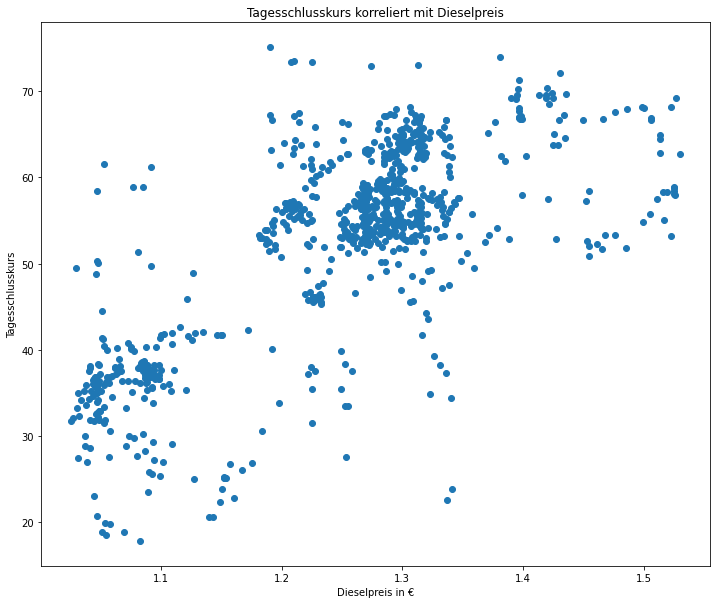

In [177]:
plt.figure(figsize=(12,10))
plt.scatter(merged_fuel_oil["diesel"], merged_fuel_oil["Schluss"])
plt.title("Tagesschlusskurs korreliert mit Dieselpreis")
plt.xlabel("Dieselpreis in €")
plt.ylabel("Tagesschlusskurs")
plt.show()

Auch hier bei dem Plot, der Super E5 und die Rohölpreise enthält, sieht man, dass die Tendenzen der Preise steigend sind. Man kann also vermuten, dass die jeweiligen Werte miteinander korrelieren.

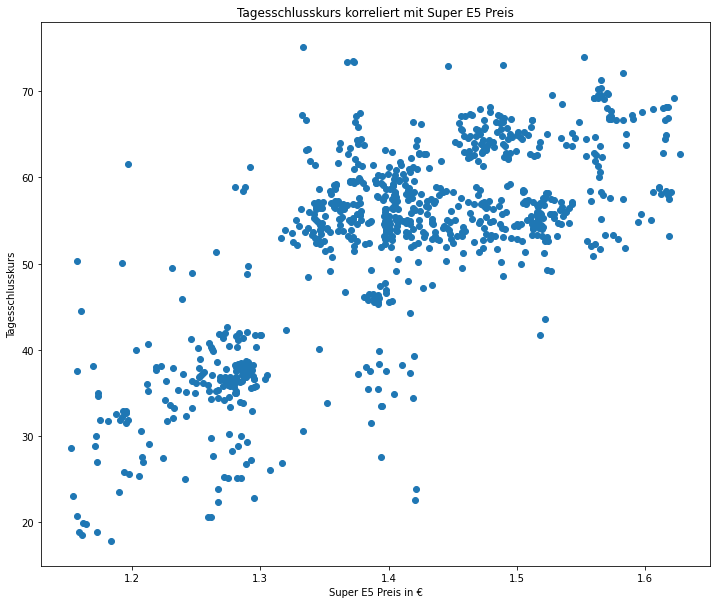

In [178]:
plt.figure(figsize=(12,10))
plt.scatter(merged_fuel_oil["e5"], merged_fuel_oil["Schluss"])
plt.title("Tagesschlusskurs korreliert mit Super E5 Preis")
plt.xlabel("Super E5 Preis in €")
plt.ylabel("Tagesschlusskurs")
plt.show()

b) <a id="aufgabe4b"></a> Berechnen Sie jeweils für Diesel und E5 den empirischen Korrelationskoeffizienten zwischen den Rohölpreisen und den Tagesmittelwerten der Kraftstoffpreise.

Um zu überprüfen, ob die Werte wirklich miteinander korrelieren, wurde zunächst der Korrelationskoeffizient ausgerechnet.

In [179]:
merged_fuel_oil['diesel'].corr(merged_fuel_oil['Schluss'])

0.734141864725257

In [180]:
merged_fuel_oil['e5'].corr(merged_fuel_oil['Schluss'])

0.7385225703915745

Auch die Werte der Korrelationskoeffizienten zeigen die oben abgebildete Tendenz. Da diese Werte mit jeweils ca. 0.73 ziemlich nah an der 1 liegen, ist der lineare Zusammenhang zwischen Rohölpreisen und Diesel bzw. Rohölpreisen und E5 stark ausgeprägt.

c) <a id="aufgabe4c"></a> Diskutieren Sie, ob lineare Modelle sinnvoll wären, um die Zusammenhänge zwischen dem Rohölpreis und den Preisen für Diesel bzw. E5 darzustellen.

Allgemein wären die Werte sicherlich geeignet, um die Daten mit einem linearen Modell darzustellen. Die Abbildungen zeigen, dass die Rohölpreise steigen, wenn auch die Kraftstoffpreise steigen. Dennoch ist der Nutzen eines linearen Modells nicht sehr sinnvoll. Der Grund hierfür liegt darin, dass die Preise sehr stark schwanken können, was ein lineares Modell nicht vorhersehen kann. So wäre ein lineares Modell zu ungenau, um den Zusammenhang zwischen Diesel- bzw. Super E5-Preisen und den Rohölpreisen zu zeigen.

## Aufgabe 5 <a id="aufgabe5"></a>
#### (Einfluss des Wettbewerbs auf die Kraftstoffpreise in Bayern)
Untersuchen Sie, welchen Einfluss der Wettbewerb zwischen mehreren Tankstellen auf die Preisgestaltung hat. Ermitteln Sie dazu zunächst für jede Tankstelle in Bayern, wie viele Tankstellen sich im Umkreis von 5km Umgebung zu ihr befindet. Speichern Sie diese Angabe in einer Spalte namens neighbors. Speichern Sie den resultierenden DataFrame df_stations_BY als CSV-Datei namens stations_BY.csv und laden Sie diese mit Ihrer Abgabe auf Moodle hoch.
Stellen Sie zunächst mögliche Hypothesen auf und untersuchen Sie diese anschließend, indem Sie geeignete Auswertungen und Visualisierungen erstellen.

### Hypothese

Wir nehmen an, dass Tankstellen die im näheren Umfeld mehr Konkurrenz haben, günstiger sind und nur kleine Preisunterschiede haben, damit die Kunden sich für die günstigen Tankstellen entscheiden. In ländlichen Gebieten gibt es nahezu keine Konkurrenz, demnach können Tankstellen die Kraftstoffpreise erhöhen, da die Kunden auf die näheste Tankstelle angewiesen sind und keinen Preisvergleich zu anderen Tankstellen im Umfeld haben.

Um die Anzahl an Nachbar-Tankstellen zu zählen, haben wir eine Methode benutzt, die den Bereich der 5km in Longitude und Latitude berechnet. Wenn also eine Koordinate zwischen den beiden max und min Werten von Longitude und Latidude ist, so ist sie ein Nachbar der Tankstelle.

In [181]:
def getNeighborCount(row, lat, lon):
    coordRadius = getRadiusCoords(lat, lon, 5)
    count = 0
    for i, rowData in df_stations_BY.iterrows():
        if row.name is not i:
            if ((rowData["longitude"] <= coordRadius[0]) & (rowData["latitude"] <= coordRadius[1]) &
                (rowData["longitude"] >= coordRadius[2]) & (rowData["latitude"] >= coordRadius[3])):
                count += 1
    return count

proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def getRadiusCoords(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)
    coords = transform(project, buf).exterior.coords[:]
    lonMax = max(coords,key=lambda item:item[0])[0]
    latMax = max(coords,key=lambda item:item[1])[1]
    lonMin = min(coords,key=lambda item:item[0])[0]
    latMin = min(coords,key=lambda item:item[1])[1]
    return [lonMax, latMax, lonMin, latMin]

Hier werden die oben beschriebenen Funktionen angewendet. Die Anzahl an Tankstellen-Nachbarn wird danach in die neue Spalte "neighbors" eingefügt.

In [182]:
df_stations_BY["neighbors"] = df_stations_BY.progress_apply(lambda x: getNeighborCount(x, x["latitude"], x["longitude"]), axis=1)

100%|██████████| 3180/3180 [20:46<00:00,  2.55it/s]


## Checkpoint Aufgabe 5, df_stations_BY, df_prices_BY <a id="checkpoint2"></a>

In [183]:
df_stations_BY.to_csv("stations_BY.csv", index=False)

In [184]:
df_stations_BY = pd.read_csv("stations_BY.csv")

Nun benennen wir die Spalte "station_uuid" in "uuid" um, damit wir diese später auf die uuid mergen können.

In [185]:
df_prices_BY.rename(columns = {"station_uuid":"uuid"}, inplace="True")

Wir erstellen einen neuen DataFrame, bei dem der Durchschnitt der Kraftstoffpreise zur uuid gebildet wird. Damit dieser wieder einen Index besitzt, wird reset_index angewendet.

In [186]:
mean_prices = df_prices_BY.groupby("uuid")[["diesel", "e5", "e10"]].mean()
mean_prices = pd.DataFrame(mean_prices)
mean_prices = mean_prices.reset_index()

Nun erstellen wir einen gemergeden Datensatz aus mean_prices und df_stations_BY. Damit haben wir nun die Preise und die Nachbarinformationen in einem DataFrame.

In [187]:
merged_price_count = mean_prices.merge(df_stations_BY[["uuid", "neighbors"]], on="uuid")

Jetzt können wir ein Streudiagramm erstellen, in denen man übersichtlich sehen kann, wie sich die Preise bei vielen oder wenigen Tankstellennachbarn verhalten.

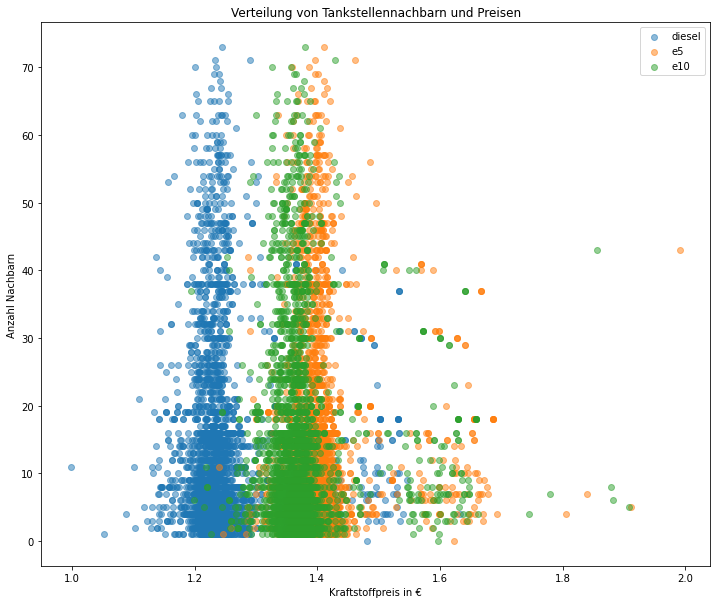

In [188]:
plt.figure(figsize=(12,10))
plt.scatter(merged_price_count["diesel"], merged_price_count["neighbors"], label="diesel", alpha=0.5)
plt.scatter(merged_price_count["e5"], merged_price_count["neighbors"], label="e5", alpha=0.5)
plt.scatter(merged_price_count["e10"], merged_price_count["neighbors"], label="e10", alpha=0.5)
plt.xlabel("Kraftstoffpreis in €")
plt.ylabel("Anzahl Nachbarn")
plt.title("Verteilung von Tankstellennachbarn und Preisen")
plt.legend()
plt.show()

## Hypothesen Analyse


Es ist zu erkennen, dass Tankstellen die wenig Nachbarn haben, eine größere empirische Varianz zum arithmetischen Mittelwert der Preise besitzen. Außerdem besitzen Tankstellen mit wenigen Nachbarn viel höhere Preise als Tankstellen mit vielen Nachbarn. Daraus lässt sich stark herauslesen, dass der Wettbewerb der Tankstellen einen großen Einfluss auf die Preisgestaltung der Kraftstoffe hat.

Außerdem lässt sich erkennen, dass ungefähr ab 40 Tankstellen-Nachbarn keine großen Preisunterschiede mehr erkennbar sind. Je weniger Nachbarn, desto mehr unterschiedliche Preise gibt es.

Unsere Hypothese hat sich hiermit bestätigt.

## Aufgabe 6 <a id="aufgabe6"></a>
#### (Tanken in Amberg, Interaktives Diagramm)
Herr Sparfuchs, der als Rentner zeitlich flexibel ist, möchte wissen, wann und wo er in Amberg derzeit am günstigsten tanken kann. Erstellen Sie dazu ein geeignetes interaktives Diagramm mit Plotly, um die Kraftstoffpreise an den Tankstellen in Amberg zu analysieren, und
leiten Sie Empfehlungen für Herrn Sparfuchs ab. Erstellen Sie für die Analyse zwei DataFrames namens df_stations_amberg und df_prices_amberg, die aus Filterung der Tankstellen und Preisdatensätze hervorgehen, und verwenden Sie ausschließlich diese für die Erzeugung des Plotly-Diagramms. Dokumentieren Sie Ihre Analyseergebnisse.

Zunächst wurden zwei neue DataFrames gebildet, die nur die Daten der Tankstellen Ambergs enthalten.

In [189]:
df_stations_amberg = df_stations.loc[df_stations["post_code"] == 92224]
df_stations_amberg = df_stations_amberg.reset_index(drop=True)

Mit Hilfe von "merge" konnten die Preislisten so gefiltert werden, dass diese nur aus "uuids" der Tankstellen bestehen, die sich in Amberg befinden.

In [190]:
df_prices_amberg = df_stations_amberg.merge(df_prices_BY[["uuid", "diesel", "e5", "e10", "date"]], on="uuid")

Da Herr Sparfuchs aktuelle Preise im Diagramm vorfinden möchte, werden nur die Datensätze aus dem Monat Mai 2021 betrachtet.Um das Diagramm auch nicht zu sehr vollzupacken, wurden die Tagesdurchschnittspreise berechnet. Wichtig ist hier zu sagen, dass der Durchschnitt der Preise einer Tankstelle immer zur gleichen Zeit berechnet wurde. So sieht man im Verlauf des Tages gut, wann die Preise wie gestiegen sind.

In [191]:
mask = df_prices_amberg['date'] >= '2021-05-1'
df_prices_amberg = df_prices_amberg.loc[mask]

In [192]:
def hourGrouper(row):
    return df_prices_amberg.at[row, "date"].hour

df_amberg_daymean = df_prices_amberg.groupby(by=["uuid", hourGrouper]).mean()

In [193]:
df_amberg_daymean = df_amberg_daymean.reset_index()
df_amberg_daymean = df_amberg_daymean.merge(df_stations_amberg[["uuid", "name"]], on="uuid")

In [194]:
df_amberg_daymean.sort_values(by=["level_1"], inplace=True)

In [195]:
df_amberg_daymean.rename(columns = {"level_1":"Stunde"}, inplace="True")

In [196]:
df_amberg_daymean

,uuid,Stunde,post_code,latitude,longitude,diesel,e5,e10,name
0,00060995-0006-4444-8888-acdc00000006,3,92224,49.451408,11.853890,1.344000,1.534000,1.474000,"Bergler Mineralöl GmbH, Amberg"
228,e0716e5c-68a9-4c88-95d7-c136fcc598cb,3,92224,49.444790,11.877495,1.393000,1.573000,1.513000,AVIA Tankstelle
71,51d4b680-a095-1aa0-e100-80009459e03a,3,92224,49.461800,11.851000,1.352846,1.555923,1.495923,JET AMBERG BAYREUTHER STR. 78
90,51d4b6ba-a095-1aa0-e100-80009459e03a,3,92224,49.443100,11.840900,1.352125,1.565875,1.505875,"Supermarkt-Tankstelle am real,- Markt AMBERG F..."
210,dd2449aa-fefb-46a7-9a75-705e862606c6,3,92224,49.442689,11.859816,1.388524,1.599476,1.539476,Esso Tankstelle
...,...,...,...,...,...,...,...,...,...
53,08f346c1-8034-4bf6-a573-3b40b2f40dff,20,92224,49.443517,11.844872,1.408677,1.603194,1.543194,AMBERG - NUERNBERGER STRASSE 2A
244,e0716e5c-68a9-4c88-95d7-c136fcc598cb,20,92224,49.444790,11.877495,1.381581,1.557710,1.497710,AVIA Tankstelle
89,51d4b680-a095-1aa0-e100-80009459e03a,21,92224,49.461800,11.851000,1.378032,1.555452,1.495452,JET AMBERG BAYREUTHER STR. 78
108,51d4b6ba-a095-1aa0-e100-80009459e03a,21,92224,49.443100,11.840900,1.370333,1.546333,1.486333,"Supermarkt-Tankstelle am real,- Markt AMBERG F..."


## Checkpoint Aufgabe 6 df_stations_amberg, df_prices_amberg <a id="checkpoint3"></a>

Um nicht jedes Mal viel Zeit in die Filterung der Daten zu stecken, werden zwei neue CSV-Dateien der Preise und der Tankstellen in Amberg gebildet.

In [199]:
df_stations_amberg.to_csv("df_stations_amberg.csv", index=False)
df_prices_amberg.to_csv("df_prices_amberg.csv", index=False)

In [200]:
df_stations_amberg = pd.read_csv("df_stations_amberg.csv")
df_prices_amberg = pd.read_csv("df_prices_amberg.csv")

In [201]:
fig = px.line(df_amberg_daymean,y=["e5", "e10", "diesel"], x="Stunde", color="name", title='Tankstellenpreise Amberg')

Im interaktiven Plotly-Diagramm kann man nun also verschieden Lineplots sehen. Im ersten Diagrammteil ist eine Übersicht aller Kraftstoffarten aller Tankstellen abgebildet. Bei einem Klick auf die Tankstellennamen auf der rechten Seite kann man Tankstellen ausblenden, falls man nur bestimmte sehen will. 
Möchte Herr Sparfuchs die Werte der einzelnen Kraftstoffarten in einer Übersicht dargestellt haben, so kann er auf die Buttons klicken, um Super E5, Super E10 oder Diesel zu erhalten.

In [202]:
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    showlegend=True,
    xaxis_title="Uhrzeit",
    yaxis_title="Kraftstoffpreis in €",
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.7,
            y=1.2,
            showactive=True,
            buttons=list(
                [
                    dict(
                        label="Vergleich",
                        method="update",
                        args=[{"visible": [True, True, True]}],
                    ),
                    dict(
                        label="E5",
                        method="update",
                        args=[{"visible": [True, False, False]}],
                    ),
                    dict(
                        label="E10",
                        method="update",
                        args=[{"visible": [False, True, False]}],
                    ),
                    dict(
                        label="Diesel",
                        method="update",
                        args=[{"visible": [False, False, True]}],
                    ),
                ]
            ),
        )
    ]
)



### Empfehlung für Herrn Sparfuchs: 
Um nun möglichst günstig tanken zu können, sollte er zwischen 14:00 Uhr und 18:00 Uhr eine Tankstelle in Amberg aufsuchen.
Um 18:00 Uhr könnte er bei der Supermarkt-Tankstelle am real,-Markt am günstigens den Kraftstoff Super E10 tanken.
Möchte er lieber Super E5 tanken, könnte er bei der SB-Markttankstelle um 19:00 Uhr am günstigsten tanken.
Fährt Herr Sparfuchs Diesel, so kann entweder um 17:00 Uhr bei der Supermarkt-Tankstelle am real,-Markt oder um 19:00 Uhr bei der SB-Markttankstelle preisgünstig tanken.

## Zusammenfassung der Analyseergebnisse

### Unscheinbarer Datensatz - viele Informationen
Etwas sehr Erstaunliches waren die Fülle an Informationen, die man aus einem vielleicht auch eher uninteressanten Datensatz bekommt. Am Anfang der Projektarbeit wirkten die Datensätze über Tankstellen und deren Preise eher unscheinbar und auch etwas langweilig. Dass man aber so viele - auch interessante - Informationen herausfiltern kann, war wirklich erstaunlich. Das zeigt, dass im Unscheinbaren durchaus Schätze liegen können.

### Vertraue keinem Datensatz
Durch die Vorbereitung des Datensatzes für Aufgabe 1, ist schnell klar geworden, dass man niemals sofort mit der Analyse der Daten beginnen sollte. Die Daten sollten immer zuerst kontrolliert und aufbereitet werden. So sind Fehler in späteren Analysefällen vermeidbar.

### Tankstellen in Deutschland
In Deutschland überwiegen die Markentankstellen deutlich, sehr viele Tankstellen haben Sonntags geöffnet und die größte Tankstellenmarke ist ARAL.

### Historische Entwicklung der Kraftstoffpreise: Starker Preissturz 2020
In dem Diagramm in Aufgabe 3b) kann man erkennen, dass 2020 während der Pandemie der Preis aller Kraftstoffe stark einstürzte. Dies könnte daran liegen, dass viele Menschen in dieser Zeit im Homeoffice beschäftigt waren und kaum Freizeitaktivitäten unternehmen konnten, bei denen man ein Auto gebraucht hätte. Die daraus resultierende Frage, die man sich nun stellen könnte, wäre: Wären die Preise auch eingebrochen, wenn es keine Pandemie gegeben hätte?

Ansonsten konnte man in jeder zeitlichen Phase erkennen, dass die Kraftstoffpreise ähnliche Preisverläufe hatten.

### Wettbewerb beeinflusst Preise
Aus der Analyse ging auch hervor, dass der Wettbewerb die Preise stark beeinflusst. Was Tankstellenpreise betrifft, gibt es schon die Vermutung, dass die Preise bei Tankstellen, die mehrere Nachbarn haben, eher gleich sind, aber, dass das wirklich zutrifft, war erstaunlich zu sehen. Auch, dass es teilweise vermutlich eher ländliche Tankstellen gibt, die dann die Preise so machen können, wie sie es für richtig halten, da es hier fast keine Konkurrenz gibt. Wenn man also wirklich günstig tanken will, sollte man das alles bedenken und in seine Überlegung zur Wahl der Tankstelle mit einbeziehen.

### Tanken in Amberg
Durch die Analyse der Tankstellendaten in Amberg und durch das ansprechende Diagramm, kann man gut erkennen, zu welchen Tageszeiten man in Amberg am günstigen tanken kann. Es ist klar zu erkennen, dass die Preise in die Höhe schießen, wenn der große Pendlerverkehr beginnt. 
Diese sind Morgens um 7:00 und 10:00, und Abends um 20:00. Diese basieren wahrscheinlich auf den durchschnittlichen Arbeitszeiten einer Person.
Wenn man in Amberg günstig tanken will, so sollte man dies zwischen 14:00 und 18:00 Uhr tun.